In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
# shapenet
dataset_type = "shapenet"
class_name = "02691156"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
input_img_dir = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# pix2mesh
input_mesh_dir = "/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)

# occnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)


# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [6]:
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

#instances = ['2394', '1517', '0191', '1598']
instances = instances[:20]
print(instances)
print(cfg)

['d2f8a99bbdc387c8c5552bebbfa48bd7', 'dd4da4309c12d47bc2c2c81e2232aa95', 'fc7c3ccb57f65337209009cfb89d4bd', 'e8ed294534ba18df4a29fef5d2b2f3d7', 'd8e8540acddacf98c1006ed55bc1a3fc', 'f24daae76836e249f0878b58b4e887bf', 'ddd6c2a51c25036c8a43cd65b179a1ff', 'f12eefbbefabe566ca8607f540cc62ba', 'd532a5abb756ebebcc14f1e6f4f4f49b', 'fb92c2e96fdf6c37595dc3191c718398', 'f70e5f2568e927147d755f57c8fea340', 'd583d6f23c590f3ec672ad25c77a396', 'd24f2a1da14a00ce16b34c3751bc447d', 'd38922599bc74f6da30fd8ce49679098', 'd1e78f6226a9ac76fb2fba771d8219ff', 'f592e88114a240cc61a8d3163a0a75a7', 'e8e1b765fdf5edfa14c19f41d007670e', 'e4665d76bf8fc441536d5be52cb9d26a', 'e9bae38bc2083d0bb4d73e4449062b04', 'eaccb2ca303223afc503a3776fc280fe']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'mod

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/d2f8a99bbdc387c8c5552bebbfa48bd7.obj
0.884615421295166 40.0 292.157958984375 gt


/home/svcl-oowl/brandon/research/sil_consistent_at_inference/evaluation.py:73: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427286/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  input_img_mask = torch.tensor(np.asarray(input_img))[:,:,3] > 0


Input mesh metrics: {'2d_iou_multi': 0.465826519454519, '2d_iou_input': 0.5223343968391418, '3d_iou': 0.0066408413, 'chamfer_L1': 0.00401482405140996, 'chamfer_L1_uniformly': 0.009844943881034851}



Refined mesh metrics: {'2d_iou_multi': 0.3043099033335845, '2d_iou_input': 0.6254950165748596, '3d_iou': 0.018211534, 'chamfer_L1': 0.01178094744682312, 'chamfer_L1_uniformly': 0.017208149656653404}


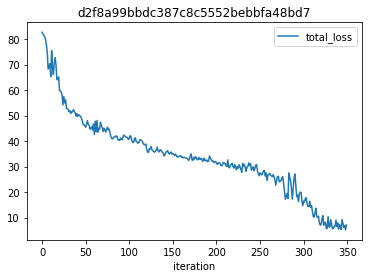

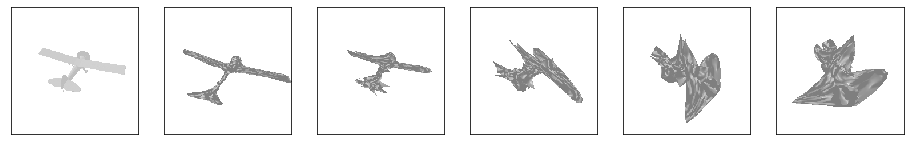

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/dd4da4309c12d47bc2c2c81e2232aa95.obj
1.1410256624221802 40.0 216.45401000976562 gt
Input mesh metrics: {'2d_iou_multi': 0.3953255545347929, '2d_iou_input': 0.5803322792053223, '3d_iou': 0.14052838, 'chamfer_L1': 0.0034122620709240437, 'chamfer_L1_uniformly': 0.0029688701033592224}



Refined mesh metrics: {'2d_iou_multi': 0.6083589550107718, '2d_iou_input': 0.7667100429534912, '3d_iou': 0.1975365, 'chamfer_L1': 0.001145327347330749, 'chamfer_L1_uniformly': 0.0019216379150748253}


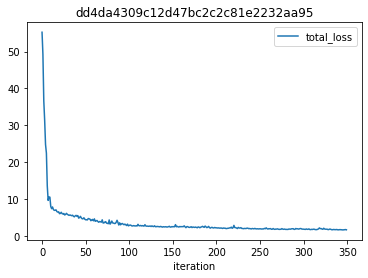

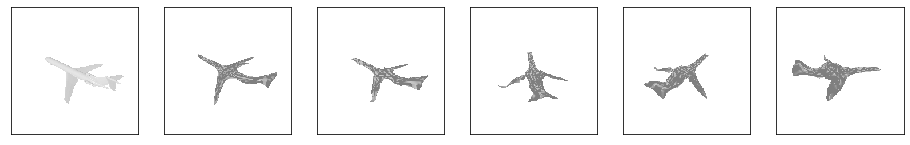

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/fc7c3ccb57f65337209009cfb89d4bd.obj
1.2051281929016113 40.0 185.21148681640625 gt
Input mesh metrics: {'2d_iou_multi': 0.3270926373079419, '2d_iou_input': 0.3078582286834717, '3d_iou': 0.054491274, 'chamfer_L1': 0.004118092358112335, 'chamfer_L1_uniformly': 0.003894164226949215}



Refined mesh metrics: {'2d_iou_multi': 0.49283135309815407, '2d_iou_input': 0.6233539581298828, '3d_iou': 0.25726497, 'chamfer_L1': 0.0007718686247244477, 'chamfer_L1_uniformly': 0.0015652421861886978}


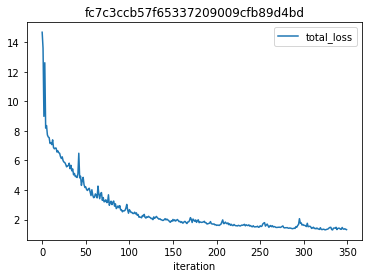

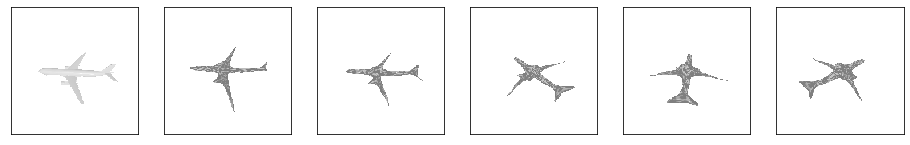

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/e8ed294534ba18df4a29fef5d2b2f3d7.obj
0.9487179517745972 40.0 289.5747375488281 gt
Input mesh metrics: {'2d_iou_multi': 0.479601239785552, '2d_iou_input': 0.7286191582679749, '3d_iou': 0.109887004, 'chamfer_L1': 0.008358044549822807, 'chamfer_L1_uniformly': 0.008887141942977905}



Refined mesh metrics: {'2d_iou_multi': 0.5681488097955784, '2d_iou_input': 0.8405134081840515, '3d_iou': 0.10046587, 'chamfer_L1': 0.004383315332233906, 'chamfer_L1_uniformly': 0.008377588354051113}


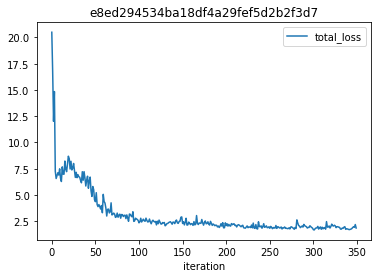

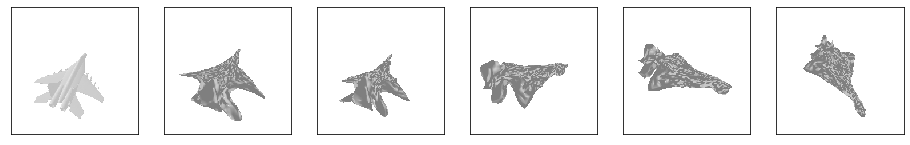

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/d8e8540acddacf98c1006ed55bc1a3fc.obj
1.0128204822540283 40.0 185.91635131835938 gt
Input mesh metrics: {'2d_iou_multi': 0.5180942695587873, '2d_iou_input': 0.5414937734603882, '3d_iou': 0.1592405, 'chamfer_L1': 0.003904999466612935, 'chamfer_L1_uniformly': 0.003782360814511776}



Refined mesh metrics: {'2d_iou_multi': 0.6498097516596317, '2d_iou_input': 0.7547400593757629, '3d_iou': 0.1949441, 'chamfer_L1': 0.001224634237587452, 'chamfer_L1_uniformly': 0.0020444535184651613}


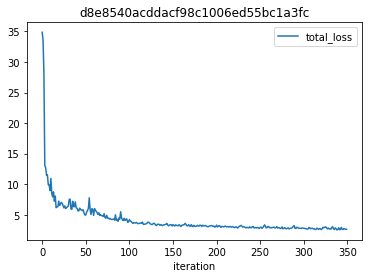

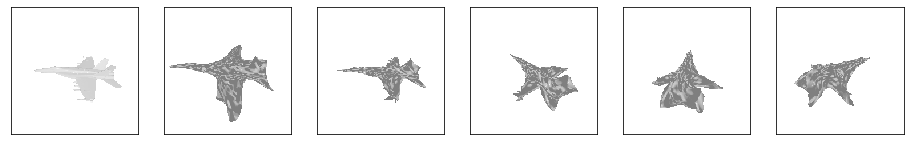

/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/02691156/rgba/f24daae76836e249f0878b58b4e887bf.obj
1.3974359035491943 40.0 33.5267333984375 gt


KeyboardInterrupt: 

In [7]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = True

results_df = pd.DataFrame()
for instance in instances:
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    print(input_mesh_path)
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
display(results_df)
print(results_df.mean())